In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import numpy as np 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data_dir = '/content/gdrive/My Drive/COVID19/Assignment 5 Dataset'

In [18]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/validation', transform=valid_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size= 8, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size= 8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size= 8, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


In [19]:
validiter = iter(validloader)
features, labels = next(validiter)
features.shape, labels.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

In [6]:
## Training Image Shapes
testiter = iter(testloader)
features, labels = next(testiter)
features.shape, labels.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

In [20]:
print("Training Data Size:",len(trainloader.dataset))
print("Validation Data Size:",len(validloader.dataset))
print("Testing Data Size:",len(testloader.dataset))

Training Data Size: 12000
Validation Data Size: 1500
Testing Data Size: 1500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


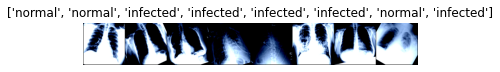

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [0]:
## Different Functions that will be used to train and evaluate performance of model.

from timeit import default_timer as timer
from tqdm import tqdm
def train(model,criterion,optimizer,train_loader,valid_loader,save_file_name,n_epochs):
  
    valid_max_acc = 0
    Model_Eval = []

    train_list_acc = []
    valid_list_acc = []
    train_list_cost = []
    valid_list_cost = []
  
    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        model.train()
        train_pbar = tqdm(enumerate(train_loader))
        for i, (data, target) in train_pbar:
      
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
           
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)

            train_pbar.set_description( 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                                         epoch, i * len(data), len(train_loader.dataset),
                                         100. * i / len(train_loader),loss.item()))

           

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_acc / len(train_loader.dataset)
      
        train_list_cost.append(train_loss)
        train_list_acc.append(train_acc)
        print("Training Accuracy at Epoch No " ,str(epoch+1) , "is ", train_acc)
        
        with torch.no_grad():
             model.eval()  
             valid_pbar = tqdm(enumerate(valid_loader))
             for j, (valid_data, valid_target) in valid_pbar:
          
                 valid_data, valid_target = valid_data.to(device), valid_target.to(device)
                 output = model(valid_data)
                 loss = criterion(output, valid_target)
                 valid_loss += loss.item() * valid_data.size(0)

                  # Calculate validation accuracy
                 _, pred = torch.max(output, dim=1)
                 correct_tensor = pred.eq(valid_target.data.view_as(pred))
                 accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                 # Multiply average accuracy times the number of examples
                 valid_acc += accuracy.item() * valid_data.size(0)

                 valid_pbar.set_description( 'Validation Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                                            .format(epoch, j * len(valid_data), len(valid_loader.dataset),
                                            100. * j / len(valid_loader),loss.item()))
               
                

      
        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_acc = valid_acc / len(valid_loader.dataset)
        
        valid_list_cost.append(valid_loss)
        valid_list_acc.append(valid_acc)
        # print("Validation Loss at Epoch No " ,(epoch+1) ," is ",valid_loss)
        print("Validation Accuracy at Epoch No " ,(epoch+1) ,"is ", valid_acc)
       
        torch.save(model.state_dict(), '/content/gdrive/My Drive/COVID19/models/'+save_file_name)
        print("Model is Successfully Saved")
        print("-------------------------------------------------------")
    
    Model_Eval.append([train_list_cost, valid_list_cost, train_list_acc, valid_list_acc])
    return model,Model_Eval

def evaluate(model,testloader):
    ## Here Evaluation Function will be written.
    model.eval()
    input, target = testloader
    predicted = model(input)

def accuracy(test_loader,model):
    correct = 0
    total = 0
    label_list= []
    pred_list = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            label_list.extend(labels.cpu().numpy())
            pred_list.extend(predicted.cpu().numpy())
          
    
    ## Going to Calculate Confusion Matrix and F1 Score Using SKLearn:

    acc_score = accuracy_score(label_list, pred_list)
    print("Accuracy Score : ",acc_score)
    
    con_matrix = confusion_matrix(label_list, pred_list) 
    print("Prining Con Matrix: ")
    print(con_matrix)

    c_report =  classification_report(label_list,pred_list) 
    print("Classification Report")
    print(c_report) 
    
def draw_accuracy_loss(model_eval,epochs):
    
    plt.figure(figsize=(8, 6))
    plt.plot(list(range(epochs)),model_eval[0][0], label="Training Loss")
    plt.plot(list(range(epochs)),model_eval[0][1], label="Validation Loss")
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy Loss')
    plt.title('Training and Validation Losses')

    plt.figure(figsize=(8, 6))
    plt.plot(list(range(epochs)),model_eval[0][2], label="Training Accuracy")
    plt.plot(list(range(epochs)),model_eval[0][3], label="Validation Accuracy")
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    


ResNet18 for COVID19


In [22]:
# Load the pretrained model from pytorch
resNet18 = models.resnet18(pretrained=True)
print(resNet18)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for param in resNet18.parameters():
    param.requires_grad = False   
    
resNet18.fc = nn.Sequential(
               nn.Linear(512, 480),
               nn.ReLU(inplace=True),
               nn.Linear(480, 2))

In [9]:
## printing updated ResNet18
print(resNet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [66]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resNet18.to(device)
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resNet18.parameters(), lr=0.001, momentum=0.9)
save_file_name = "res18_FC_Only1.pth’"

model,model_eval = train(resNet18,criterion,optimizer,trainloader,validloader,save_file_name,Epochs)

Train Epoch: 0 [11992/12000 (100%)]	Loss: 0.194343: : 1500it [05:16,  4.74it/s]
Validation Epoch: 0 [0/1500 (0%)]	Loss: 0.212149: : 1it [00:00,  5.47it/s]

Training Accuracy at Epoch No  1 is  0.86275


Validation Epoch: 0 [748/1500 (99%)]	Loss: 0.074031: : 188it [00:31,  6.00it/s]
0it [00:00, ?it/s]

Validation Accuracy at Epoch No  1 is  0.8693333333333333
Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 1 [11992/12000 (100%)]	Loss: 0.225247: : 1500it [05:12,  4.79it/s]
0it [00:00, ?it/s]

Training Accuracy at Epoch No  2 is  0.8641666666666666


Validation Epoch: 1 [748/1500 (99%)]	Loss: 0.230585: : 188it [00:31,  5.96it/s]


Validation Accuracy at Epoch No  2 is  0.8626666666666667


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 2 [11992/12000 (100%)]	Loss: 0.459820: : 1500it [05:11,  4.81it/s]
Validation Epoch: 2 [0/1500 (0%)]	Loss: 0.190658: : 1it [00:00,  5.27it/s]

Training Accuracy at Epoch No  3 is  0.8670833333333333


Validation Epoch: 2 [748/1500 (99%)]	Loss: 0.958434: : 188it [00:31,  6.06it/s]
0it [00:00, ?it/s]

Validation Accuracy at Epoch No  3 is  0.876
Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 3 [11992/12000 (100%)]	Loss: 0.408808: : 1500it [05:10,  4.83it/s]
Validation Epoch: 3 [0/1500 (0%)]	Loss: 0.843250: : 1it [00:00,  5.91it/s]

Training Accuracy at Epoch No  4 is  0.86925


Validation Epoch: 3 [748/1500 (99%)]	Loss: 0.535549: : 188it [00:30,  6.19it/s]
0it [00:00, ?it/s]

Validation Accuracy at Epoch No  4 is  0.868
Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 4 [11992/12000 (100%)]	Loss: 0.121299: : 1500it [05:10,  4.83it/s]
Validation Epoch: 4 [0/1500 (0%)]	Loss: 0.228430: : 1it [00:00,  5.59it/s]

Training Accuracy at Epoch No  5 is  0.8695


Validation Epoch: 4 [748/1500 (99%)]	Loss: 0.171834: : 188it [00:30,  6.14it/s]
0it [00:00, ?it/s]

Validation Accuracy at Epoch No  5 is  0.85
Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 5 [11992/12000 (100%)]	Loss: 0.552558: : 1500it [05:09,  4.84it/s]
Validation Epoch: 5 [0/1500 (0%)]	Loss: 0.491784: : 1it [00:00,  5.66it/s]

Training Accuracy at Epoch No  6 is  0.8701666666666666


Validation Epoch: 5 [748/1500 (99%)]	Loss: 1.503723: : 188it [00:30,  6.20it/s]
0it [00:00, ?it/s]

Validation Accuracy at Epoch No  6 is  0.862
Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 6 [11992/12000 (100%)]	Loss: 0.555141: : 1500it [05:11,  4.82it/s]
Validation Epoch: 6 [0/1500 (0%)]	Loss: 0.273439: : 1it [00:00,  5.67it/s]

Training Accuracy at Epoch No  7 is  0.8733333333333333


Validation Epoch: 6 [748/1500 (99%)]	Loss: 0.047783: : 188it [00:30,  6.20it/s]
0it [00:00, ?it/s]

Validation Accuracy at Epoch No  7 is  0.8713333333333333
Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 7 [11992/12000 (100%)]	Loss: 0.639230: : 1500it [05:12,  4.80it/s]
Validation Epoch: 7 [0/1500 (0%)]	Loss: 0.101885: : 1it [00:00,  5.44it/s]

Training Accuracy at Epoch No  8 is  0.8708333333333333


Validation Epoch: 7 [748/1500 (99%)]	Loss: 0.178236: : 188it [00:30,  6.20it/s]
0it [00:00, ?it/s]

Validation Accuracy at Epoch No  8 is  0.8593333333333333
Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 8 [11992/12000 (100%)]	Loss: 0.385487: : 1500it [05:11,  4.82it/s]
Validation Epoch: 8 [0/1500 (0%)]	Loss: 0.139842: : 1it [00:00,  5.62it/s]

Training Accuracy at Epoch No  9 is  0.874


Validation Epoch: 8 [748/1500 (99%)]	Loss: 0.110586: : 188it [00:30,  6.15it/s]
0it [00:00, ?it/s]

Validation Accuracy at Epoch No  9 is  0.87
Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 9 [11992/12000 (100%)]	Loss: 0.609888: : 1500it [05:11,  4.82it/s]
Validation Epoch: 9 [0/1500 (0%)]	Loss: 0.181172: : 1it [00:00,  5.55it/s]

Training Accuracy at Epoch No  10 is  0.8745833333333334


Validation Epoch: 9 [748/1500 (99%)]	Loss: 0.642063: : 188it [00:30,  6.08it/s]


Validation Accuracy at Epoch No  10 is  0.874
Model is Successfully Saved
-------------------------------------------------------


In [67]:
accuracy(testloader,model) 

Accuracy Score :  0.938
Prining Con Matrix: 
[[562  53]
 [ 40 845]]
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       615
           1       0.94      0.95      0.95       885

    accuracy                           0.94      1500
   macro avg       0.94      0.93      0.94      1500
weighted avg       0.94      0.94      0.94      1500



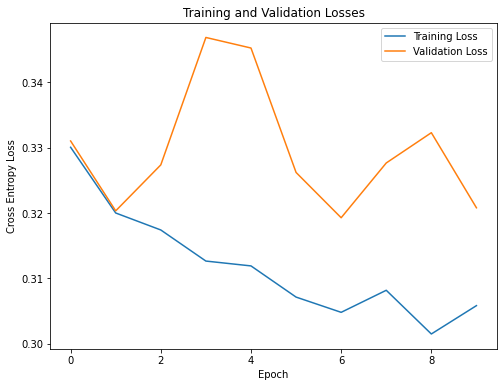

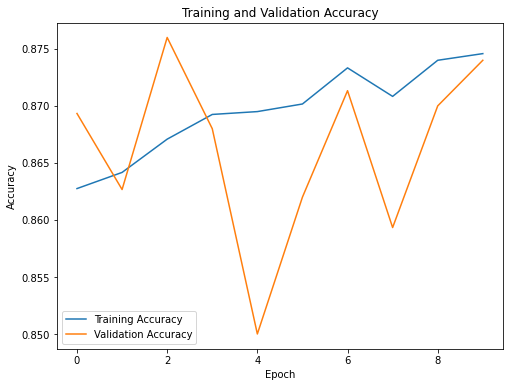

In [68]:
draw_accuracy_loss(model_eval,10)

 **VGG16 for COVID19**
 

In [70]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [0]:
# Freeze training for all layers

for param in vgg16.features.parameters():
    param.require_grad = False
   
    

In [72]:
vgg16.classifier = nn.Sequential(
                      nn.Linear(25088,480,bias=True), 
                      nn.ReLU(inplace= True), 
                      nn.Dropout(p = 0.5,inplace=False),
                      nn.Linear(480,2,bias=True),                  
                     )
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
Epochs = 13
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.8)
save_file_name = "vgg16_FC_Only1.pth"

model,model_eval = train(vgg16,criterion,optimizer,trainloader,validloader,save_file_name,Epochs)

Train Epoch: 0 [11992/12000 (100%)]	Loss: 0.365392: : 1500it [06:59,  3.57it/s]
0it [00:00, ?it/s]

Training Accuracy at Epoch No  1 is  0.8846666666666667


Validation Epoch: 0 [748/1500 (99%)]	Loss: 0.155134: : 188it [00:34,  5.42it/s]


Validation Accuracy at Epoch No  1 is  0.8973333333333333


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 1 [11992/12000 (100%)]	Loss: 0.429353: : 1500it [06:53,  3.63it/s]
0it [00:00, ?it/s]

Training Accuracy at Epoch No  2 is  0.927


Validation Epoch: 1 [748/1500 (99%)]	Loss: 0.126651: : 188it [00:35,  5.30it/s]


Validation Accuracy at Epoch No  2 is  0.9013333333333333


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 2 [11992/12000 (100%)]	Loss: 0.020450: : 1500it [06:57,  3.59it/s]
0it [00:00, ?it/s]

Training Accuracy at Epoch No  3 is  0.931


Validation Epoch: 2 [748/1500 (99%)]	Loss: 1.157770: : 188it [00:36,  5.15it/s]


Validation Accuracy at Epoch No  3 is  0.9066666666666666


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 3 [11992/12000 (100%)]	Loss: 0.021615: : 1500it [07:05,  3.53it/s]
0it [00:00, ?it/s]

Training Accuracy at Epoch No  4 is  0.93725


Validation Epoch: 3 [748/1500 (99%)]	Loss: 0.861570: : 188it [00:37,  5.03it/s]


Validation Accuracy at Epoch No  4 is  0.912


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 4 [11992/12000 (100%)]	Loss: 0.014357: : 1500it [07:27,  3.35it/s]
0it [00:00, ?it/s]

Training Accuracy at Epoch No  5 is  0.9410833333333334


Validation Epoch: 4 [748/1500 (99%)]	Loss: 0.162443: : 188it [00:37,  5.02it/s]


Validation Accuracy at Epoch No  5 is  0.9126666666666666


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 5 [11992/12000 (100%)]	Loss: 0.160206: : 1500it [07:03,  3.54it/s]
0it [00:00, ?it/s]

Training Accuracy at Epoch No  6 is  0.9444166666666667


Validation Epoch: 5 [748/1500 (99%)]	Loss: 0.027080: : 188it [00:35,  5.30it/s]


Validation Accuracy at Epoch No  6 is  0.918


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 6 [11992/12000 (100%)]	Loss: 0.230521: : 1500it [06:53,  3.63it/s]
Validation Epoch: 6 [0/1500 (0%)]	Loss: 0.277319: : 1it [00:00,  5.18it/s]

Training Accuracy at Epoch No  7 is  0.9445


Validation Epoch: 6 [748/1500 (99%)]	Loss: 0.315943: : 188it [00:35,  5.33it/s]


Validation Accuracy at Epoch No  7 is  0.9226666666666666


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 7 [11992/12000 (100%)]	Loss: 0.032966: : 1500it [06:52,  3.63it/s]
0it [00:00, ?it/s]

Training Accuracy at Epoch No  8 is  0.9486666666666667


Validation Epoch: 7 [748/1500 (99%)]	Loss: 0.307166: : 188it [00:35,  5.28it/s]


Validation Accuracy at Epoch No  8 is  0.9206666666666666


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 8 [11992/12000 (100%)]	Loss: 0.075611: : 1500it [06:52,  3.64it/s]
0it [00:00, ?it/s]

Training Accuracy at Epoch No  9 is  0.95


Validation Epoch: 8 [748/1500 (99%)]	Loss: 0.393622: : 188it [00:35,  5.37it/s]


Validation Accuracy at Epoch No  9 is  0.9193333333333333


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 9 [11992/12000 (100%)]	Loss: 0.125106: : 1500it [06:54,  3.62it/s]
0it [00:00, ?it/s]

Training Accuracy at Epoch No  10 is  0.9533333333333334


Validation Epoch: 9 [748/1500 (99%)]	Loss: 0.002732: : 188it [00:35,  5.30it/s]


Validation Accuracy at Epoch No  10 is  0.92


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 10 [11992/12000 (100%)]	Loss: 0.008254: : 1500it [06:58,  3.59it/s]
Validation Epoch: 10 [0/1500 (0%)]	Loss: 0.383720: : 1it [00:00,  5.26it/s]

Training Accuracy at Epoch No  11 is  0.95575


Validation Epoch: 10 [748/1500 (99%)]	Loss: 0.002247: : 188it [00:35,  5.31it/s]


Validation Accuracy at Epoch No  11 is  0.9193333333333333


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 11 [11992/12000 (100%)]	Loss: 0.208127: : 1500it [06:59,  3.58it/s]
Validation Epoch: 11 [0/1500 (0%)]	Loss: 0.027319: : 1it [00:00,  5.18it/s]

Training Accuracy at Epoch No  12 is  0.9583333333333334


Validation Epoch: 11 [748/1500 (99%)]	Loss: 0.013715: : 188it [00:35,  5.23it/s]


Validation Accuracy at Epoch No  12 is  0.912


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 12 [11992/12000 (100%)]	Loss: 0.019750: : 1500it [07:05,  3.53it/s]
Validation Epoch: 12 [0/1500 (0%)]	Loss: 0.113897: : 0it [00:00, ?it/s]

Training Accuracy at Epoch No  13 is  0.9595


Validation Epoch: 12 [748/1500 (99%)]	Loss: 0.289103: : 188it [00:35,  5.26it/s]


Validation Accuracy at Epoch No  13 is  0.9166666666666666
Model is Successfully Saved
-------------------------------------------------------


In [74]:
accuracy(testloader,model) 

Accuracy Score :  0.9733333333333334
Prining Con Matrix: 
[[589  26]
 [ 14 871]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       615
           1       0.97      0.98      0.98       885

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



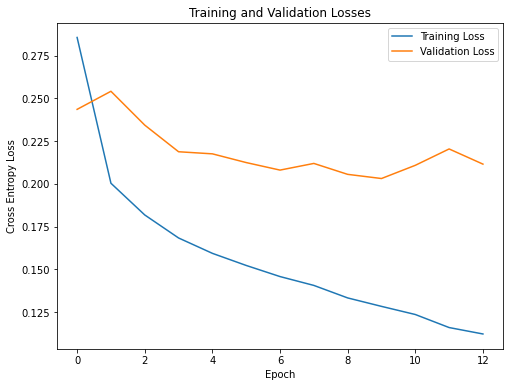

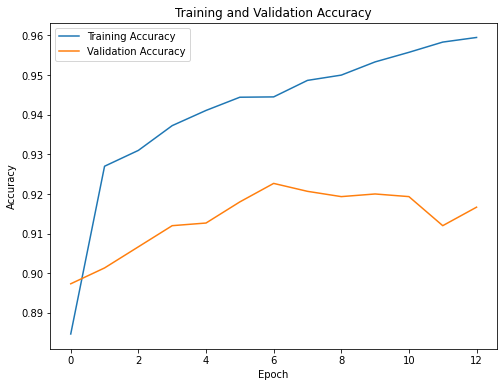

In [75]:
draw_accuracy_loss(model_eval,13)

### **Task2**

**Full Layer VGG18 Training**

In [86]:
# Load the pretrained model from pytorch
vgg16_2 = models.vgg16(pretrained=True)
print(vgg16_2)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:

for param in vgg16_2.features.parameters():
    param.require_grad = True
    

In [91]:
vgg16_2.classifier = nn.Sequential(
                      nn.Linear(25088,480,bias=True), 
                      nn.ReLU(inplace= True), 
                      nn.Dropout(p = 0.5,inplace=False),
                      nn.Linear(480,2,bias=True),                  
                     )
print(vgg16_2)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [92]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16_2.to(device)
Epochs = 13
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16_2.parameters(), lr=0.0001, momentum=0.8)
file_name = "vgg16_entire1.pth"

for p in optimizer.param_groups[0]['params']:
    if p.requires_grad is True:
        print(p.shape)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([480, 25088])
torch.Size([480])
torch.Size([2, 480])
torch.Size([2])


In [93]:
model,model_eval = train(vgg16_2,criterion,optimizer,trainloader,validloader,file_name,Epochs)

Train Epoch: 0 [11992/12000 (100%)]	Loss: 0.129604: : 1500it [07:11,  3.48it/s]
0it [00:00, ?it/s]

Training Accuracy at Epoch No  1 is  0.8859166666666667


Validation Epoch: 0 [748/1500 (99%)]	Loss: 0.087961: : 188it [00:35,  5.33it/s]


Validation Accuracy at Epoch No  1 is  0.8993333333333333


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 1 [11992/12000 (100%)]	Loss: 0.151738: : 1500it [06:52,  3.64it/s]
0it [00:00, ?it/s]

Training Accuracy at Epoch No  2 is  0.9250833333333334


Validation Epoch: 1 [748/1500 (99%)]	Loss: 0.299106: : 188it [00:35,  5.28it/s]


Validation Accuracy at Epoch No  2 is  0.9066666666666666


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 2 [11992/12000 (100%)]	Loss: 0.039634: : 1500it [06:57,  3.59it/s]
0it [00:00, ?it/s]

Training Accuracy at Epoch No  3 is  0.9335


Validation Epoch: 2 [748/1500 (99%)]	Loss: 0.851487: : 188it [00:35,  5.29it/s]


Validation Accuracy at Epoch No  3 is  0.8986666666666666


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 3 [11992/12000 (100%)]	Loss: 0.138057: : 1500it [06:55,  3.61it/s]
Validation Epoch: 3 [0/1500 (0%)]	Loss: 0.433799: : 1it [00:00,  5.08it/s]

Training Accuracy at Epoch No  4 is  0.9368333333333333


Validation Epoch: 3 [748/1500 (99%)]	Loss: 0.073607: : 188it [00:34,  5.38it/s]


Validation Accuracy at Epoch No  4 is  0.9106666666666666


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 4 [11992/12000 (100%)]	Loss: 0.034582: : 1500it [06:53,  3.63it/s]
0it [00:00, ?it/s]

Training Accuracy at Epoch No  5 is  0.9401666666666667


Validation Epoch: 4 [748/1500 (99%)]	Loss: 1.070608: : 188it [00:35,  5.35it/s]


Validation Accuracy at Epoch No  5 is  0.9133333333333333


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 5 [11992/12000 (100%)]	Loss: 0.026462: : 1500it [07:01,  3.56it/s]
0it [00:00, ?it/s]

Training Accuracy at Epoch No  6 is  0.9428333333333333


Validation Epoch: 5 [748/1500 (99%)]	Loss: 0.011428: : 188it [00:35,  5.27it/s]


Validation Accuracy at Epoch No  6 is  0.9146666666666666


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 6 [11992/12000 (100%)]	Loss: 0.016056: : 1500it [07:01,  3.56it/s]
Validation Epoch: 6 [0/1500 (0%)]	Loss: 0.058990: : 1it [00:00,  5.10it/s]

Training Accuracy at Epoch No  7 is  0.94575


Validation Epoch: 6 [748/1500 (99%)]	Loss: 0.015638: : 188it [00:35,  5.30it/s]


Validation Accuracy at Epoch No  7 is  0.9113333333333333


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 7 [11992/12000 (100%)]	Loss: 0.011470: : 1500it [07:01,  3.56it/s]
Validation Epoch: 7 [0/1500 (0%)]	Loss: 0.068275: : 1it [00:00,  5.09it/s]

Training Accuracy at Epoch No  8 is  0.9504166666666667


Validation Epoch: 7 [748/1500 (99%)]	Loss: 0.366306: : 188it [00:35,  5.28it/s]


Validation Accuracy at Epoch No  8 is  0.9126666666666666


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 8 [11992/12000 (100%)]	Loss: 0.006303: : 1500it [07:01,  3.56it/s]
0it [00:00, ?it/s]

Training Accuracy at Epoch No  9 is  0.9521666666666667


Validation Epoch: 8 [748/1500 (99%)]	Loss: 0.006922: : 188it [00:36,  5.19it/s]


Validation Accuracy at Epoch No  9 is  0.916


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 9 [11992/12000 (100%)]	Loss: 0.008623: : 1500it [07:02,  3.55it/s]
Validation Epoch: 9 [0/1500 (0%)]	Loss: 0.017818: : 1it [00:00,  5.19it/s]

Training Accuracy at Epoch No  10 is  0.9538333333333333


Validation Epoch: 9 [748/1500 (99%)]	Loss: 0.085222: : 188it [00:36,  5.21it/s]


Validation Accuracy at Epoch No  10 is  0.9126666666666666


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 10 [11992/12000 (100%)]	Loss: 0.209462: : 1500it [07:20,  3.41it/s]
0it [00:00, ?it/s]

Training Accuracy at Epoch No  11 is  0.9530833333333333


Validation Epoch: 10 [748/1500 (99%)]	Loss: 0.016225: : 188it [00:38,  4.95it/s]


Validation Accuracy at Epoch No  11 is  0.9153333333333333


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 11 [11992/12000 (100%)]	Loss: 0.041958: : 1500it [07:11,  3.48it/s]
0it [00:00, ?it/s]

Training Accuracy at Epoch No  12 is  0.9568333333333333


Validation Epoch: 11 [748/1500 (99%)]	Loss: 1.668966: : 188it [00:36,  5.19it/s]


Validation Accuracy at Epoch No  12 is  0.9206666666666666


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 12 [11992/12000 (100%)]	Loss: 0.012762: : 1500it [07:05,  3.53it/s]
0it [00:00, ?it/s]

Training Accuracy at Epoch No  13 is  0.9591666666666666


Validation Epoch: 12 [748/1500 (99%)]	Loss: 0.034873: : 188it [00:37,  5.06it/s]


Validation Accuracy at Epoch No  13 is  0.9186666666666666
Model is Successfully Saved
-------------------------------------------------------


In [94]:
accuracy(testloader,model) 

Accuracy Score :  0.9706666666666667
Prining Con Matrix: 
[[581  34]
 [ 10 875]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       615
           1       0.96      0.99      0.98       885

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



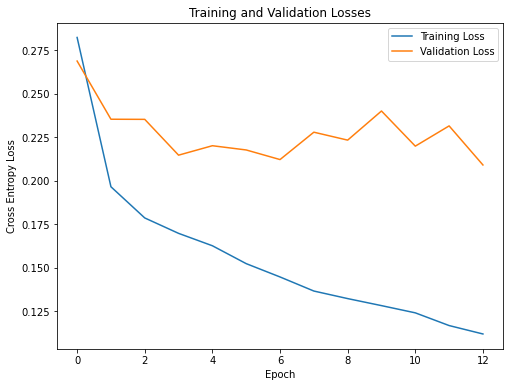

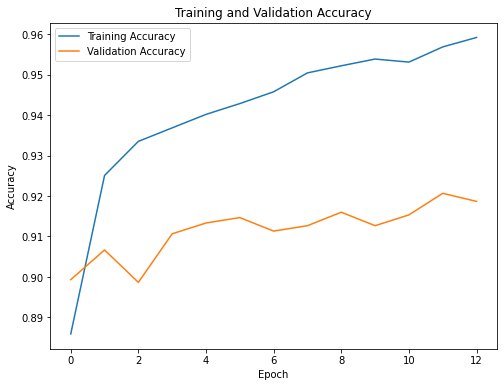

In [95]:
draw_accuracy_loss(model_eval,13)

**Full Layer ResNet18 Training:**



In [96]:
print(resNet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for param in resNet18.parameters():
    param.requires_grad = True  

In [101]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resNet18.to(device)
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resNet18.parameters(), lr=0.001, momentum=0.9)
file_name = "res18_entire1.pth"

for p in optimizer.param_groups[0]['params']:
    if p.requires_grad is True:
        print(p.shape)

torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
t

In [102]:
model,model_eval = train(resNet18,criterion,optimizer,trainloader,validloader,file_name,Epochs)

Train Epoch: 0 [11992/12000 (100%)]	Loss: 0.042440: : 1500it [05:51,  4.27it/s]
Validation Epoch: 0 [0/1500 (0%)]	Loss: 0.344912: : 1it [00:00,  5.28it/s]

Training Accuracy at Epoch No  1 is  0.88475


Validation Epoch: 0 [748/1500 (99%)]	Loss: 0.470814: : 188it [00:32,  5.71it/s]


Validation Accuracy at Epoch No  1 is  0.9073333333333333


0it [00:00, ?it/s]

Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 1 [11992/12000 (100%)]	Loss: 0.052926: : 1500it [05:43,  4.37it/s]
Validation Epoch: 1 [0/1500 (0%)]	Loss: 0.666575: : 1it [00:00,  5.17it/s]

Training Accuracy at Epoch No  2 is  0.91725


Validation Epoch: 1 [748/1500 (99%)]	Loss: 0.116026: : 188it [00:31,  5.93it/s]
0it [00:00, ?it/s]

Validation Accuracy at Epoch No  2 is  0.8973333333333333
Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 2 [11992/12000 (100%)]	Loss: 0.023613: : 1500it [05:36,  4.46it/s]
Validation Epoch: 2 [0/1500 (0%)]	Loss: 0.328942: : 1it [00:00,  5.80it/s]

Training Accuracy at Epoch No  3 is  0.93375


Validation Epoch: 2 [748/1500 (99%)]	Loss: 0.068522: : 188it [00:30,  6.07it/s]
0it [00:00, ?it/s]

Validation Accuracy at Epoch No  3 is  0.9046666666666666
Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 3 [11992/12000 (100%)]	Loss: 0.014129: : 1500it [05:39,  4.42it/s]
Validation Epoch: 3 [0/1500 (0%)]	Loss: 0.780918: : 1it [00:00,  5.79it/s]

Training Accuracy at Epoch No  4 is  0.9413333333333334


Validation Epoch: 3 [748/1500 (99%)]	Loss: 0.134081: : 188it [00:30,  6.08it/s]
0it [00:00, ?it/s]

Validation Accuracy at Epoch No  4 is  0.922
Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 4 [11992/12000 (100%)]	Loss: 0.481567: : 1500it [05:33,  4.50it/s]
Validation Epoch: 4 [0/1500 (0%)]	Loss: 0.248641: : 1it [00:00,  5.28it/s]

Training Accuracy at Epoch No  5 is  0.9425


Validation Epoch: 4 [748/1500 (99%)]	Loss: 0.713355: : 188it [00:30,  6.15it/s]
0it [00:00, ?it/s]

Validation Accuracy at Epoch No  5 is  0.9206666666666666
Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 5 [11992/12000 (100%)]	Loss: 0.087855: : 1500it [05:32,  4.51it/s]
Validation Epoch: 5 [0/1500 (0%)]	Loss: 0.716024: : 1it [00:00,  5.57it/s]

Training Accuracy at Epoch No  6 is  0.9510833333333333


Validation Epoch: 5 [748/1500 (99%)]	Loss: 0.280170: : 188it [00:30,  6.08it/s]
0it [00:00, ?it/s]

Validation Accuracy at Epoch No  6 is  0.9193333333333333
Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 6 [11992/12000 (100%)]	Loss: 0.047631: : 1500it [05:38,  4.43it/s]
Validation Epoch: 6 [0/1500 (0%)]	Loss: 0.029808: : 1it [00:00,  5.55it/s]

Training Accuracy at Epoch No  7 is  0.9516666666666667


Validation Epoch: 6 [748/1500 (99%)]	Loss: 0.445451: : 188it [00:30,  6.07it/s]
0it [00:00, ?it/s]

Validation Accuracy at Epoch No  7 is  0.9286666666666666
Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 7 [11992/12000 (100%)]	Loss: 0.031738: : 1500it [05:34,  4.48it/s]
Validation Epoch: 7 [0/1500 (0%)]	Loss: 0.021736: : 1it [00:00,  5.66it/s]

Training Accuracy at Epoch No  8 is  0.955


Validation Epoch: 7 [748/1500 (99%)]	Loss: 1.080171: : 188it [00:30,  6.08it/s]
0it [00:00, ?it/s]

Validation Accuracy at Epoch No  8 is  0.9213333333333333
Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 8 [11992/12000 (100%)]	Loss: 0.095598: : 1500it [05:34,  4.49it/s]
Validation Epoch: 8 [0/1500 (0%)]	Loss: 0.006667: : 1it [00:00,  5.81it/s]

Training Accuracy at Epoch No  9 is  0.9576666666666667


Validation Epoch: 8 [748/1500 (99%)]	Loss: 0.006916: : 188it [00:31,  6.00it/s]
0it [00:00, ?it/s]

Validation Accuracy at Epoch No  9 is  0.9186666666666666
Model is Successfully Saved
-------------------------------------------------------


Train Epoch: 9 [11992/12000 (100%)]	Loss: 0.011598: : 1500it [05:33,  4.49it/s]
Validation Epoch: 9 [0/1500 (0%)]	Loss: 0.413715: : 1it [00:00,  5.64it/s]

Training Accuracy at Epoch No  10 is  0.9625


Validation Epoch: 9 [748/1500 (99%)]	Loss: 0.017344: : 188it [00:30,  6.14it/s]


Validation Accuracy at Epoch No  10 is  0.9166666666666666
Model is Successfully Saved
-------------------------------------------------------


In [103]:
accuracy(testloader,model) 

Accuracy Score :  0.9673333333333334
Prining Con Matrix: 
[[600  15]
 [ 34 851]]
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       615
           1       0.98      0.96      0.97       885

    accuracy                           0.97      1500
   macro avg       0.96      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



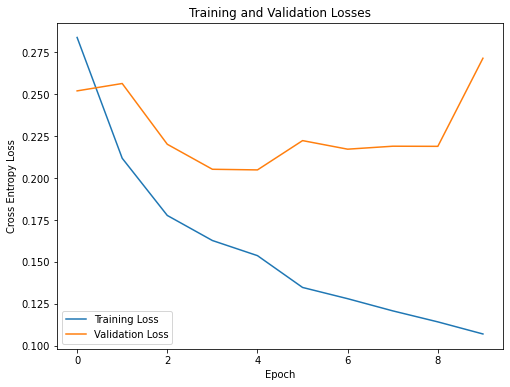

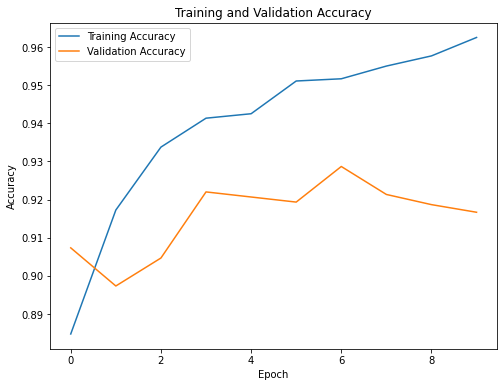

In [104]:
draw_accuracy_loss(model_eval,10)